In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import h5py
from PIL import Image
import os

# Make sure plots display inline
%matplotlib inline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# ======================
# COPY YOUR MODEL CLASS FROM TRAINING
# ======================

class SegFormerLandslide128(torch.nn.Module):
    def __init__(self, num_classes=1, input_size=128, output_size=128):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        from transformers import SegformerConfig, SegformerForSemanticSegmentation
        
        # Load configuration and modify for 128 channels
        config = SegformerConfig.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
        config.num_channels = 128
        config.num_labels = num_classes
        
        # Load model with modified configuration
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512",
            config=config,
            ignore_mismatched_sizes=True
        )
        
        # More efficient upsampling
        self.upsample = torch.nn.Upsample(size=output_size, mode='bilinear', align_corners=True)
        
    def forward(self, x):
        outputs = self.segformer(x).logits
        return self.upsample(outputs)

print("✅ Model class defined!")

✅ Model class defined!


In [3]:
# ======================
# LOAD TRAINED MODEL
# ======================

def load_trained_model(model_path):
    """Load your trained landslide detection model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🚀 Loading model on: {device}")
    
    # Initialize model architecture
    model = SegFormerLandslide128(num_classes=1, input_size=128, output_size=128)
    
    # Load trained weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()  # Set to evaluation mode
    
    print("✅ Model loaded successfully!")
    return model, device

# UPDATE THIS PATH to your actual model file
MODEL_PATH = "/home/neel/Geog_project/best_landslide_model_128ch.pth"  # Change this!

# Load the model
model, device = load_trained_model(MODEL_PATH)

print(f"📊 Model device: {next(model.parameters()).device}")

🚀 Loading model on: cuda


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
- segformer.encoder.patch_embeddings.0.proj.weight: found shape torch.Size([32, 3, 7, 7]) in the checkpoint and torch.Size([32, 128, 7, 7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully!
📊 Model device: cuda:0


In [4]:
# ======================
# DATA PREPROCESSING
# ======================

def load_new_data_from_h5(h5_path, sample_idx=0):
    """Load new 128-channel data from HDF5 file"""
    try:
        with h5py.File(h5_path, 'r') as f:
            # Get first dataset key
            key = list(f.keys())[0]
            data = f[key][sample_idx]  # Load specific sample
            
            print(f"📊 Loaded data shape: {data.shape}")
            print(f"📊 Data range: [{data.min():.3f}, {data.max():.3f}]")
            
            return data
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

def preprocess_128channel_data(data):
    """Preprocess new 128-channel data exactly like training"""
    if isinstance(data, np.ndarray):
        data = data.astype(np.float32)
    
    # Ensure 128 channels
    if len(data.shape) == 2:
        # Single channel - repeat to 128 (unlikely but safe)
        data = np.stack([data] * 128, axis=-1)
    elif len(data.shape) == 3:
        if data.shape[0] == 128 and data.shape[2] == 128:
            # Shape is (128, height, width) - convert to (height, width, 128)
            data = np.transpose(data, (1, 2, 0))
    
    # Handle channel count
    if data.shape[-1] > 128:
        data = data[:, :, :128]
    elif data.shape[-1] < 128:
        padding = np.zeros((data.shape[0], data.shape[1], 128 - data.shape[-1]), dtype=data.dtype)
        data = np.concatenate([data, padding], axis=-1)
    
    # Normalize each channel (same as training)
    for c in range(data.shape[-1]):
        channel_data = data[:, :, c]
        if np.std(channel_data) > 0:
            data[:, :, c] = (channel_data - np.mean(channel_data)) / np.std(channel_data)
    
    # Resize to 128x128 if needed
    if data.shape[0] != 128 or data.shape[1] != 128:
        resized_data = np.zeros((128, 128, 128), dtype=np.float32)
        for c in range(128):
            resized_data[:, :, c] = cv2.resize(data[:, :, c], (128, 128), interpolation=cv2.INTER_LINEAR)
        data = resized_data
    
    # Convert to PyTorch tensor
    tensor_data = torch.from_numpy(data).float().permute(2, 0, 1)  # (128, 128, 128) -> (128, 128, 128)
    tensor_data = tensor_data.unsqueeze(0)  # Add batch dimension: (1, 128, 128, 128)
    
    return tensor_data

print("✅ Data functions defined!")

✅ Data functions defined!


In [95]:
# ======================
# LOAD TEST DATA
# ======================

# UPDATE THIS PATH to your test HDF5 file
TEST_DATA_PATH = "/home/neel/Geog_project/Landslide4Sense_1/TestData/img/image_1.h5"  # CHANGE THIS!
SAMPLE_INDEX = 10  # Which sample to test

print(f"📥 Loading test data from: {TEST_DATA_PATH}")
test_data = load_new_data_from_h5(TEST_DATA_PATH, SAMPLE_INDEX)

if test_data is None:
    print("❌ Failed to load test data. Using random data for demonstration.")
    # Create random test data with same shape for demonstration
    test_data = np.random.randn(128, 128, 128).astype(np.float32)
    print(f"📊 Using random data with shape: {test_data.shape}")

print(f"✅ Test data ready!")

📥 Loading test data from: /home/neel/Geog_project/Landslide4Sense_1/TestData/img/image_1.h5
📊 Loaded data shape: (128, 14)
📊 Data range: [0.099, 3.950]
✅ Test data ready!


In [96]:
# ======================
# MAKE PREDICTIONS
# ======================

def predict_landslides(model, device, input_data):
    """Make landslide predictions"""
    # Preprocess
    input_tensor = preprocess_128channel_data(input_data)
    input_tensor = input_tensor.to(device)
    
    print(f"🎯 Input tensor shape: {input_tensor.shape}")
    
    # Prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.sigmoid(outputs)  # Convert to probabilities [0,1]
        binary_mask = (probabilities > 0.5).float()  # Binary mask at 0.5 threshold
    
    return probabilities.cpu().numpy(), binary_mask.cpu().numpy()

print("🎯 Making predictions...")
probabilities, binary_mask = predict_landslides(model, device, test_data)

print(f"📊 Prediction probabilities shape: {probabilities.shape}")
print(f"📊 Binary mask shape: {binary_mask.shape}")

🎯 Making predictions...
🎯 Input tensor shape: torch.Size([1, 128, 128, 128])
📊 Prediction probabilities shape: (1, 1, 128, 128)
📊 Binary mask shape: (1, 1, 128, 128)


In [97]:
# ======================
# ANALYZE RESULTS
# ======================

def analyze_prediction(binary_mask, probabilities):
    """Analyze prediction results"""
    total_pixels = binary_mask.size
    landslide_pixels = np.sum(binary_mask > 0)
    landslide_percentage = (landslide_pixels / total_pixels) * 100
    
    print(f"📊 PREDICTION ANALYSIS:")
    print(f"   • Total pixels: {total_pixels:,}")
    print(f"   • Landslide pixels: {landslide_pixels:,}")
    print(f"   • Landslide coverage: {landslide_percentage:.2f}%")
    print(f"   • Max probability: {probabilities.max():.3f}")
    print(f"   • Min probability: {probabilities.min():.3f}")
    print(f"   • Mean probability: {probabilities.mean():.3f}")
    
    return landslide_percentage

landslide_percentage = analyze_prediction(binary_mask, probabilities)

📊 PREDICTION ANALYSIS:
   • Total pixels: 16,384
   • Landslide pixels: 0
   • Landslide coverage: 0.00%
   • Max probability: 0.180
   • Min probability: 0.000
   • Mean probability: 0.003


📊 Creating false color visualizations...
📊 Original data shape: (128, 14)
📊 Available channels: 1


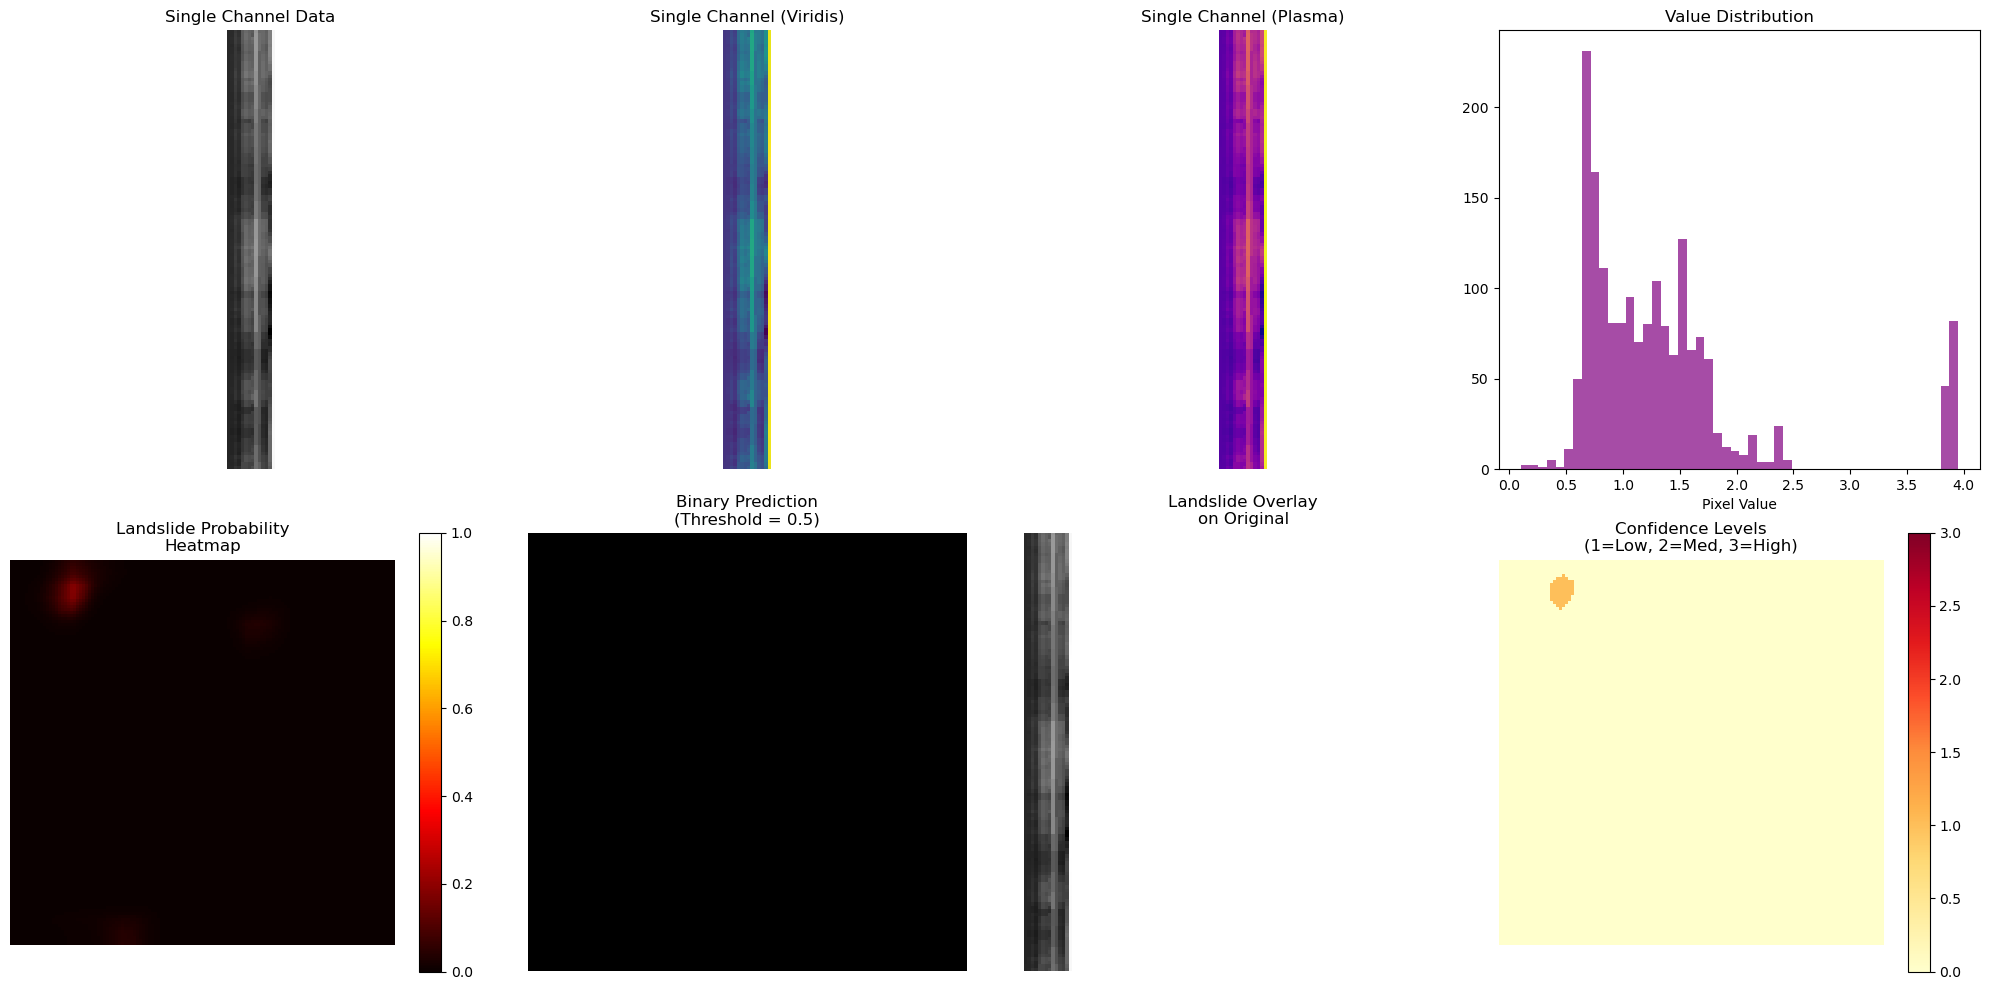

In [98]:
# ======================
# VISUALIZE RESULTS WITH FALSE COLOR COMPOSITES
# ======================

def create_false_color_composite(data, red_channel=0, green_channel=1, blue_channel=2):
    """Create false color composite from multi-channel data"""
    # Handle both 2D and 3D data
    if len(data.shape) == 2:
        # Single channel - use for all three
        red = data
        green = data
        blue = data
    else:
        # Multi-channel data
        red = data[:, :, red_channel] if data.shape[2] > red_channel else data[:, :, 0]
        green = data[:, :, green_channel] if data.shape[2] > green_channel else data[:, :, min(1, data.shape[2]-1)]
        blue = data[:, :, blue_channel] if data.shape[2] > blue_channel else data[:, :, min(2, data.shape[2]-1)]
    
    # Stack and normalize
    false_color = np.stack([red, green, blue], axis=-1)
    false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min() + 1e-8)
    
    return false_color

def visualize_prediction_with_false_color(original_data, probabilities, binary_mask):
    """Visualize with false color composites for remote sensing data"""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    print(f"📊 Original data shape: {original_data.shape}")
    print(f"📊 Available channels: {original_data.shape[2] if len(original_data.shape) == 3 else 1}")
    
    # Create different false color composites
    if len(original_data.shape) == 3 and original_data.shape[2] >= 3:
        # Natural Color (RGB-like) - using first 3 channels
        natural_color = create_false_color_composite(original_data, 0, 1, 2)
        axes[0, 0].imshow(natural_color)
        axes[0, 0].set_title('False Color: Channels 0-1-2\n(First 3 bands)')
        axes[0, 0].axis('off')
        
        # False Color Infrared (Vegetation) - common in remote sensing
        if original_data.shape[2] >= 7:
            # Typical: NIR-R-G (channels 4, 0, 1) or similar
            vegetation_composite = create_false_color_composite(original_data, 4, 0, 1)
            axes[0, 1].imshow(vegetation_composite)
            axes[0, 1].set_title('False Color: Channels 4-0-1\n(Common vegetation)')
        else:
            # Use available channels
            vegetation_composite = create_false_color_composite(original_data, 
                                                              min(2, original_data.shape[2]-1), 
                                                              0, 1)
            axes[0, 1].imshow(vegetation_composite)
            axes[0, 1].set_title('False Color: Custom Composite')
        axes[0, 1].axis('off')
        
        # Urban/Geology Composite
        if original_data.shape[2] >= 9:
            urban_composite = create_false_color_composite(original_data, 6, 3, 1)
            axes[0, 2].imshow(urban_composite)
            axes[0, 2].set_title('False Color: Channels 6-3-1\n(Urban/Geology)')
        else:
            urban_composite = create_false_color_composite(original_data, 
                                                         min(original_data.shape[2]-1, 2), 
                                                         min(original_data.shape[2]-1, 1), 
                                                         0)
            axes[0, 2].imshow(urban_composite)
            axes[0, 2].set_title('False Color: Available Bands')
        axes[0, 2].axis('off')
        
        # Custom interesting combination
        if original_data.shape[2] >= 12:
            custom_composite = create_false_color_composite(original_data, 8, 5, 2)
            axes[0, 3].imshow(custom_composite)
            axes[0, 3].set_title('False Color: Channels 8-5-2\n(Custom combination)')
        else:
            # Show single channel histogram
            axes[0, 3].hist(original_data[:, :, 0].flatten(), bins=50, alpha=0.7, color='red', label='Ch 0')
            if original_data.shape[2] > 1:
                axes[0, 3].hist(original_data[:, :, 1].flatten(), bins=50, alpha=0.7, color='green', label='Ch 1')
            if original_data.shape[2] > 2:
                axes[0, 3].hist(original_data[:, :, 2].flatten(), bins=50, alpha=0.7, color='blue', label='Ch 2')
            axes[0, 3].set_title('Channel Value Distribution')
            axes[0, 3].legend()
        
    else:
        # 2D data - show different visualizations
        axes[0, 0].imshow(original_data, cmap='gray')
        axes[0, 0].set_title('Single Channel Data')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(original_data, cmap='viridis')
        axes[0, 1].set_title('Single Channel (Viridis)')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(original_data, cmap='plasma')
        axes[0, 2].set_title('Single Channel (Plasma)')
        axes[0, 2].axis('off')
        
        axes[0, 3].hist(original_data.flatten(), bins=50, alpha=0.7, color='purple')
        axes[0, 3].set_title('Value Distribution')
        axes[0, 3].set_xlabel('Pixel Value')
    
    # PREDICTION VISUALIZATIONS
    # Probability heatmap
    prob_map = axes[1, 0].imshow(probabilities[0, 0], cmap='hot', vmin=0, vmax=1)
    axes[1, 0].set_title('Landslide Probability\nHeatmap')
    axes[1, 0].axis('off')
    plt.colorbar(prob_map, ax=axes[1, 0])
    
    # Binary prediction
    axes[1, 1].imshow(binary_mask[0, 0], cmap='gray')
    axes[1, 1].set_title(f'Binary Prediction\n(Threshold = 0.5)')
    axes[1, 1].axis('off')
    
    # Overlay on best false color composite
    if len(original_data.shape) == 3 and original_data.shape[2] >= 3:
        base_image = create_false_color_composite(original_data, 0, 1, 2)  # Natural color
        axes[1, 2].imshow(base_image)
        overlay = binary_mask[0, 0]
        axes[1, 2].imshow(overlay, cmap='Reds', alpha=0.6 * overlay)
        axes[1, 2].set_title('Landslide Overlay\non False Color')
    else:
        axes[1, 2].imshow(original_data, cmap='gray')
        overlay = binary_mask[0, 0]
        axes[1, 2].imshow(overlay, cmap='Reds', alpha=0.6 * overlay)
        axes[1, 2].set_title('Landslide Overlay\non Original')
    axes[1, 2].axis('off')
    
    # Confidence levels
    confidence_levels = np.zeros_like(probabilities[0, 0])
    confidence_levels[probabilities[0, 0] > 0.7] = 3  # High confidence
    confidence_levels[(probabilities[0, 0] > 0.3) & (probabilities[0, 0] <= 0.7)] = 2  # Medium
    confidence_levels[(probabilities[0, 0] > 0.1) & (probabilities[0, 0] <= 0.3)] = 1  # Low
    
    if np.any(confidence_levels > 0):
        conf_map = axes[1, 3].imshow(confidence_levels, cmap='YlOrRd', vmin=0, vmax=3)
        axes[1, 3].set_title('Confidence Levels\n(1=Low, 2=Med, 3=High)')
        axes[1, 3].axis('off')
        plt.colorbar(conf_map, ax=axes[1, 3])
    else:
        # Show probability distribution instead
        axes[1, 3].hist(probabilities[0, 0].flatten(), bins=50, alpha=0.7, color='orange')
        axes[1, 3].set_title('Probability Distribution')
        axes[1, 3].set_xlabel('Probability')
        axes[1, 3].axvline(x=0.5, color='red', linestyle='--', label='Threshold')
        axes[1, 3].legend()
    
    plt.tight_layout()
    plt.show()

print("📊 Creating false color visualizations...")
visualize_prediction_with_false_color(test_data, probabilities, binary_mask)

In [86]:
# ======================
# CHANNEL EXPLORER
# ======================

def explore_channels(data, num_channels_to_show=12):
    """Explore what's in your 128 channels"""
    if len(data.shape) == 3:
        print(f"🔍 EXPLORING {min(num_channels_to_show, data.shape[2])} OF {data.shape[2]} CHANNELS:")
        
        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        axes = axes.flatten()
        
        for i in range(min(num_channels_to_show, data.shape[2])):
            channel_data = data[:, :, i]
            
            axes[i].imshow(channel_data, cmap='viridis')
            axes[i].set_title(f'Channel {i}\nRange: [{channel_data.min():.2f}, {channel_data.max():.2f}]')
            axes[i].axis('off')
            
            print(f"   Channel {i:3d}: range [{channel_data.min():8.3f}, {channel_data.max():8.3f}], "
                  f"mean: {channel_data.mean():8.3f}, std: {channel_data.std():8.3f}")
        
        # Hide unused subplots
        for i in range(min(num_channels_to_show, data.shape[2]), len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
    else:
        print("📊 Single channel data - no multiple channels to explore")

# Explore your channels
explore_channels(test_data)

📊 Single channel data - no multiple channels to explore


In [81]:
# ======================
# INTERACTIVE BAND COMBINATION TESTER
# ======================

def test_band_combinations(data, combinations=None):
    """Test different band combinations for false color"""
    if len(data.shape) != 3:
        print("❌ Need 3D data for band combinations")
        return
    
    if combinations is None:
        # Common remote sensing band combinations
        combinations = {
            'Natural Color': (0, 1, 2),
            'Color Infrared': (3, 0, 1),  # NIR, Red, Green
            'Shortwave IR': (4, 2, 1),    # SWIR, Green, Blue  
            'Geology': (6, 3, 1),         # SWIR2, NIR, Green
            'Agriculture': (5, 3, 1),     # Red Edge, NIR, Green
            'Urban': (6, 4, 2),           # SWIR2, SWIR1, Blue
        }
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, (name, (r, g, b)) in enumerate(combinations.items()):
        if idx >= len(axes):
            break
            
        # Check if bands exist
        if r < data.shape[2] and g < data.shape[2] and b < data.shape[2]:
            false_color = create_false_color_composite(data, r, g, b)
            axes[idx].imshow(false_color)
            axes[idx].set_title(f'{name}\nBands: {r}-{g}-{b}')
        else:
            axes[idx].text(0.5, 0.5, f'Bands {r}-{g}-{b}\nNot available', 
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(f'{name}\n(Unavailable)')
        
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Test common band combinations
if len(test_data.shape) == 3:
    print("🎨 Testing common band combinations...")
    test_band_combinations(test_data)